In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# The Keras functional API

 ## Coding tutorials
 #### [1. Multiple inputs and outputs](#coding_tutorial_1)
 #### [2. Tensors and Variables](#coding_tutorial_2)
 #### [3. Accessing model layers](#coding_tutorial_3)
 #### [4. Freezing layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Multiple inputs and outputs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the acute inflammations dataset

The `acute inflammations` was created by a medical expert as a data set to test the expert system, which will perform the presumptive diagnosis of two diseases of the urinary system. You can find out more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

Attribute information:

Inputs:
- Temperature of patient : 35C-42C
- Occurrence of nausea : yes/no
- Lumbar pain : yes/no
- Urine pushing (continuous need for urination) : yes/no
- Micturition pains : yes/no
- Burning of urethra, itch, swelling of urethra outlet : yes/no

Outputs:
- decision 1: Inflammation of urinary bladder : yes/no
- decision 2: Nephritis of renal pelvis origin : yes/no

#### Load the data

In [3]:
# Load the dataset

from sklearn.model_selection import train_test_split

pd_dat = pd.read_csv('data/diagnosis.csv')

In [4]:
pd_dat.head()

,0,1,2,3,4,5,6,7
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0


In [5]:
pd_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
0    120 non-null float64
1    120 non-null int64
2    120 non-null int64
3    120 non-null int64
4    120 non-null int64
5    120 non-null int64
6    120 non-null int64
7    120 non-null int64
dtypes: float64(1), int64(7)
memory usage: 7.6 KB


In [6]:
dataset = pd_dat.values

In [7]:
type(dataset)

numpy.ndarray

In [8]:
dataset.shape

(120, 8)

In [9]:
# Build train and test data splits

X_train, X_test, Y_train, Y_test = train_test_split(dataset[:,:6], dataset[:,6:], test_size=0.33)

In [10]:
# Assign training and testing inputs/outputs

temp_train, nocc_train, lumbp_train, up_train, mict_train, bis_train = np.transpose(X_train)
temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test = np.transpose(X_test)

inflam_train, nephr_train = Y_train[:, 0], Y_train[:, 1]
inflam_test, nephr_test = Y_test[:, 0], Y_test[:, 1]

#### Build the model

In [25]:
# Build the input layers

from tensorflow.keras import Input, layers

shape_inputs = (1,)
temperature = Input(shape=shape_inputs, name='temp')
nausea_occurence = Input(shape=shape_inputs, name='nocc')
lumbar_pain = Input(shape=shape_inputs, name='lumbp')
urine_pushing = Input(shape=shape_inputs, name='up')
micturition_pains = Input(shape=shape_inputs, name='mict')
bis = Input(shape=shape_inputs, name='bis')

In [26]:
# Create a list of all the inputs

list_inputs = [temperature, nausea_occurence, lumbar_pain, urine_pushing, 
               micturition_pains, bis]

In [27]:
# Merge all input features into a single large vector

x = layers.concatenate(list_inputs)

In [28]:
x.shape

TensorShape([None, 6])

In [29]:
# Use a logistic regression classifier for disease prediction

inflammation_pred = layers.Dense(1, activation='sigmoid', name='inflam')(x)
nephritis_pred = layers.Dense(1, activation='sigmoid', name='nephr')(x)

In [30]:
# Create a list of all the outputs

list_outputs = [inflammation_pred, nephritis_pred]

In [31]:
# Create the model object

model = tf.keras.Model(inputs=list_inputs, outputs=list_outputs)

#### Plot the model

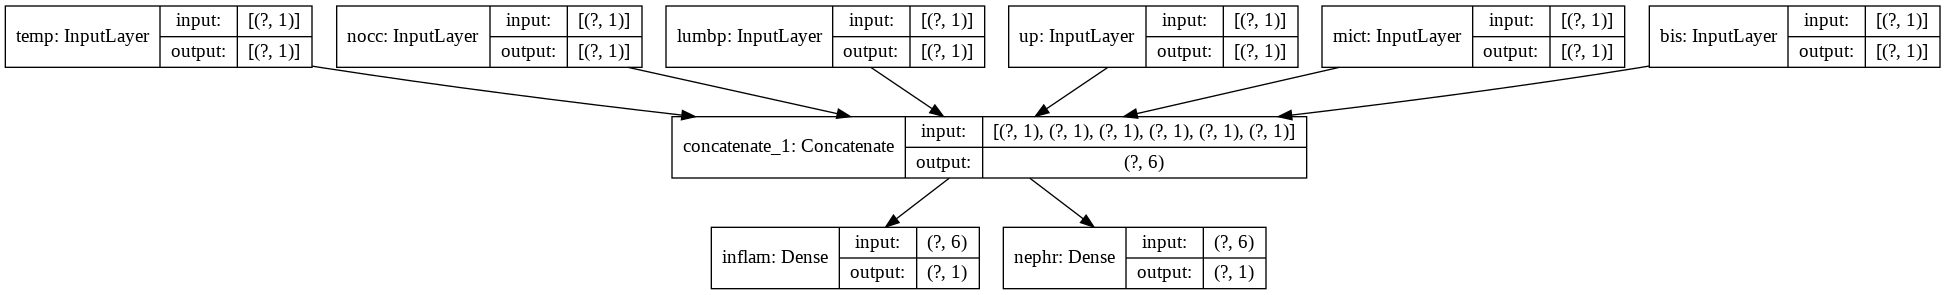

In [32]:
# Display the multiple input/output model

tf.keras.utils.plot_model(model, 'multi_input_output_model.png', show_shapes=True)

#### Compile the model

In [33]:
# Compile the model

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss={'inflam': 'binary_crossentropy', 'nephr': 'binary_crossentropy'},
    metrics={'inflam': ['acc'], 'nephr': ['acc']},
    loss_weights=[1., 0.2]
)

#### Fit the model 

In [34]:
# Define training inputs and outputs

inputs_train = {'temp': temp_train, 'nocc': nocc_train, 'lumbp': lumbp_train,
                'up': up_train, 'mict': mict_train, 'bis': bis_train}

outputs_train = {'inflam': inflam_train, 'nephr': nephr_train}

In [35]:
# Train the model

history = model.fit(inputs_train, outputs_train,
                    epochs=1000,
                    batch_size=128,
                    verbose=False
)


#### Plot the learning curves

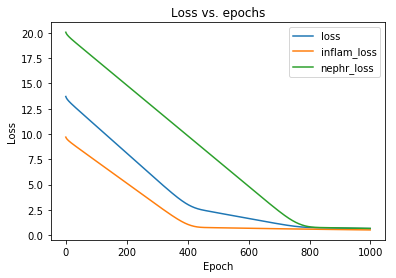

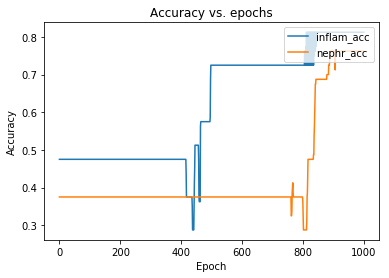

In [36]:
# Plot the training accuracy

acc_keys = [k for k in history.history.keys() if k in ('inflam_acc', 'nephr_acc')] 
loss_keys = [k for k in history.history.keys() if not k in acc_keys]

for k, v in history.history.items():
    if k in acc_keys:
        plt.figure(1)
        plt.plot(v)
    else:
        plt.figure(2)
        plt.plot(v)

plt.figure(1)
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(acc_keys, loc='upper right')

plt.figure(2)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loss_keys, loc='upper right')

plt.show()

In [37]:
# Evaluate the model

model.evaluate([temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test],
               [inflam_test, nephr_test],
               verbose=2
)

40/1 - 0s - loss: 0.7196 - inflam_loss: 0.5398 - nephr_loss: 0.8339 - inflam_acc: 0.8750 - nephr_acc: 0.7250


[0.6674132823944092, 0.5398027, 0.83387923, 0.875, 0.725]

***
<a id="coding_tutorial_2"></a>
## Tensors and Variables

In [3]:
import numpy as np

#### Create Variable objects

In [4]:
# Create Variable objects of different type with tf.Variable

strings = tf.Variable(["Hello world!"], tf.string)
floats  = tf.Variable([3.14159, 2.71828], tf.float64)
ints = tf.Variable([1, 2, 3], tf.int32)
complexs = tf.Variable([25.9 - 7.39j, 1.23 - 4.91j], tf.complex128)

In [5]:
# Initialise a Variable value

tf.Variable(tf.constant(4.2, shape=(3, 3)))

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2]], dtype=float32)>

#### Use and modify Variable values

In [6]:
# Use the value of a Variable

v = tf.Variable(0.0)
w = v + 1  # w is a tf.Tensor which is computed based on the value of v.

print(type(w))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [7]:
print(type(v))

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


In [8]:
# Increment the value of a Variable

v.assign_add(1)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


In [9]:
# Decrement the value of a Variable

v.assign_sub(1)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>


#### Create Tensor objects

Create a constant tensor and print its type as well as its shape:

In [10]:
# Create a constant Tensor

x = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(x)
print("dtype:", x.dtype)
print("shape:", x.shape)

tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)
dtype: <dtype: 'int32'>
shape: (3, 3)


In [11]:
# Obtain the value as a numpy array

x.numpy()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]], dtype=int32)

In [12]:
# Create a Tensor of type float32

x = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=tf.float32)
print(x)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]], shape=(3, 3), dtype=float32)


In [13]:
# Create coefficients

coeffs = np.arange(16)
print(coeffs)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [14]:
# Initialise shapes

shape1 = [8, 2]
shape2 = [4, 4]
shape3 = [2, 2, 2, 2]

In [15]:
# Create Tensors of different shape

a = tf.constant(coeffs, shape=shape1)
print("\n a:\n ", a)

b = tf.constant(coeffs, shape=shape2)
print("\n b:\n ", b)

c = tf.constant(coeffs, shape=shape3)
print("\n c:\n ", c)


 a:
  tf.Tensor(
[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]], shape=(8, 2), dtype=int64)

 b:
  tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]], shape=(4, 4), dtype=int64)

 c:
  tf.Tensor(
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]], shape=(2, 2, 2, 2), dtype=int64)


#### Useful Tensor operations

In [16]:
# Create a constant Tensor

t = tf.constant(np.arange(80), shape=[5,2,8])

In [17]:
# Get the rank of a Tensor

rank = tf.rank(t)

In [18]:
# Display the rank

print("rank: ", rank)

rank:  tf.Tensor(3, shape=(), dtype=int32)


In [21]:
# Reshape a Tensor

t2 = tf.reshape(t, [8, 10])

In [22]:
# Display the new shape

print("t2.shape: ", t2.shape)

t2.shape:  (8, 10)


In [23]:
print(tf.rank(t2))

tf.Tensor(2, shape=(), dtype=int32)


In [25]:
# Create ones, zeros, identity and constant Tensors

ones = tf.ones(shape=(2, 3))
zeros = tf.zeros(shape=(2, 4))
eye = tf.eye(3)
tensor7 = tf.constant(7., shape=(2, 2))

In [26]:
# Display the created tensors

print("\n Ones:\n ", ones)
print("\n Zeros:\n ", zeros)
print("\n Identity:\n ", eye)
print("\n Tensor filled with 7: ", tensor7)


 Ones:
  tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)

 Zeros:
  tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(2, 4), dtype=float32)

 Identity:
  tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)

 Tensor filled with 7:  tf.Tensor(
[[7. 7.]
 [7. 7.]], shape=(2, 2), dtype=float32)


In [27]:
# Create a ones Tensor and a zeros Tensor

t1 = tf.ones(shape=(2, 2))
t2 = tf.zeros(shape=(2, 2))

In [28]:
# Concatentate two Tensors

concat0 = tf.concat([t1, t2], 0)
concat1 = tf.concat([t1, t2], 1)

In [29]:
# Display the concatenated tensors

print(concat0)
print(concat1)

tf.Tensor(
[[1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[1. 1. 0. 0.]
 [1. 1. 0. 0.]], shape=(2, 4), dtype=float32)


In [30]:
# Create a constant Tensor

t = tf.constant(np.arange(24), shape=(3, 2, 4))
print("\n t shape: ", t.shape)


 t shape:  (3, 2, 4)


In [34]:
# Expanding the rank of Tensors

t1 = tf.expand_dims(t, 0)
t2 = tf.expand_dims(t, 1)
t3 = tf.expand_dims(t, 3)

In [35]:
# Display the shapes after tf.expand_dims

print("\n After expanding dims:\n t1 shape: ", t1.shape, "\n t2 shape: ", t2.shape, "\n t3 shape: ", t3.shape)


 After expanding dims:
 t1 shape:  (1, 3, 2, 4) 
 t2 shape:  (3, 1, 2, 4) 
 t3 shape:  (3, 2, 4, 1)


In [36]:
# Squeezing redundant dimensions

t1 = tf.squeeze(t1)
t2 = tf.squeeze(t2)
t3 = tf.squeeze(t3)

In [37]:
# Display the shapes after tf.squeeze

print("\n After squeezing:\n t1 shape: ", t1.shape, "\n t2 shape: ", t2.shape, "\n t3 shape: ", t3.shape)


 After squeezing:
 t1 shape:  (3, 2, 4) 
 t2 shape:  (3, 2, 4) 
 t3 shape:  (3, 2, 4)


In [39]:
# Slicing a Tensor

x = tf.constant(np.arange(8))
print(x)
print(x[1:-3])

tf.Tensor([0 1 2 3 4 5 6 7], shape=(8,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)


#### Doing maths with Tensors

In [41]:
# Create two constant Tensors

c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])

In [42]:
# Matrix multiplication

matmul_cd = tf.matmul(c, d)

In [43]:
# Display the result

print("\n tf.matmul(c,d):\n", matmul_cd)


 tf.matmul(c,d):
 tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [48]:
# Elementwise operations

c_times_d = c * d
c_plus_d = c + d
c_minus_d = c - d
c_div_c = c / c

In [49]:
# Display the results

print("\n c*d:\n", c_times_d)
print("\n c+d:\n", c_plus_d)
print("\n c-d:\n", c_minus_d)
print("\n c/c:\n", c_div_c)


 c*d:
 tf.Tensor(
[[1. 2.]
 [0. 4.]], shape=(2, 2), dtype=float32)

 c+d:
 tf.Tensor(
[[2. 3.]
 [3. 5.]], shape=(2, 2), dtype=float32)

 c-d:
 tf.Tensor(
[[0. 1.]
 [3. 3.]], shape=(2, 2), dtype=float32)

 c/c:
 tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


In [50]:
# Create Tensors

a = tf.constant([[2, 3], [3, 3]])
b = tf.constant([[8, 7], [2, 3]])
x = tf.constant([[-6.89 + 1.78j], [-2.54 + 2.15j]])

In [51]:
# Absolute value of a Tensor

absx = tf.abs(x)

In [52]:
# Power of a Tensor

powaa = tf.pow(a, a)

In [53]:
# Display the results

print("\n ", absx)
print("\n ", powaa)


  tf.Tensor(
[[7.11621388]
 [3.32777704]], shape=(2, 1), dtype=float64)

  tf.Tensor(
[[ 4 27]
 [27 27]], shape=(2, 2), dtype=int32)


#### Randomly sampled constant tensors

In [60]:
# Create a Tensor with samples from a Normal distribution

tn = tf.random.normal(shape=(2, 2), mean=0, stddev=1.)
print(tn)

tf.Tensor(
[[ 0.44754204 -0.8025431 ]
 [-0.05027578  0.3494013 ]], shape=(2, 2), dtype=float32)


In [61]:
# Create a Tensor with samples from a Uniform distribution

tu = tf.random.uniform(shape=(2, 1), minval=0, maxval=10, dtype='int32')
print(tu)

tf.Tensor(
[[6]
 [5]], shape=(2, 1), dtype=int32)


In [62]:
# Create a Tensor with samples from a Poisson distribution

tp = tf.random.poisson((2, 2), 5)
print(tp)

tf.Tensor(
[[3. 7.]
 [8. 6.]], shape=(2, 2), dtype=float32)


In [63]:
# More maths operations

d = tf.square(tn)
e = tf.exp(d)
f = tf.cos(c)

***
<a id="coding_tutorial_3"></a>
## Accessing model layers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the pre-trained model

In this section, we aim to demonstrate accessing layer attributes within a model.

Let's get started by loading the `VGG19` pre-trained model from the `keras.applications` library, which is a very deep network trained on more than a million images from the ImageNet database. The network is trained to classify images into 1000 object categories.

In [ ]:
# Load the VGG19 model



In [ ]:
# Get the inputs, layers and display the summary

vgg_input = vgg_model.input
vgg_layers = vgg_model.layers
vgg_model.summary()

#### Build a model to access the layer outputs

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
# Build a model that returns the layer outputs



In [ ]:
# Plot the model



In [ ]:
# Test the model on a random input



#### Load the 'cool cat' picture

In Zambia’s South Luangwa National Park, a photographer had been watching a pride of lions while they slept off a feast from a buffalo kill. When this female walked away, he anticipated that she might be going for a drink and so he positioned his vehicle on the opposite side of the waterhole. The `cool cat` picture is one of the highly commended 2018 Image from Wildlife Photographer of the Year.

In [ ]:
# Display the original image

import IPython.display as display
from PIL import Image

display.display(Image.open('data/cool_cat.jpg'))

#### Visualise network features from the input image

In [ ]:
# Preprocess the image

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

img_path = 'data/cool_cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
# Extract the features



In [ ]:
# Visualise the input channels



In [ ]:
# Visualise some features in the first hidden layer



In [ ]:
# Build a model to extract features by layer name



In [ ]:
# Visualise some features from the extracted layer output



In [ ]:
# Extract features from a layer deeper in the network



In [ ]:
# Visualise some features from the extracted layer output



***
<a id="coding_tutorial_4"></a>
## Freezing layers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Build the model

In [ ]:
# Build a small Sequential model

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    layers.Dense(4, input_shape=(4,), activation='relu', kernel_initializer='random_uniform',
                 bias_initializer='ones'),
    layers.Dense(2, activation='relu', kernel_initializer='lecun_normal', bias_initializer='ones'),
    layers.Dense(4, activation='softmax'),
])

In [ ]:
# Display the model summary

model.summary()

#### Examine the weight matrix variation over training

In [ ]:
# Retrieve the weights and biases



In [ ]:
# Construct a synthetic dataset

x_train = np.random.random((100, 4))
y_train = x_train

x_test = np.random.random((20, 4))
y_test = x_test

In [ ]:
# Compile and fit the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

model.fit(x_train, y_train, epochs=50, verbose=False);

In [ ]:
# Retrieve weights and biases



In [ ]:
# Plot the variation

plt.figure(figsize=(8,8))
for n in range(3):
    delta_l = W1_layers[n] - W0_layers[n]
    print('Layer '+str(n)+': bias variation: ', np.linalg.norm(b1_layers[n] - b0_layers[n]))
    ax = plt.subplot(1,3,n+1)
    plt.imshow(delta_l)
    plt.title('Layer '+str(n))
    plt.axis('off')
plt.colorbar()
plt.suptitle('Weight matrices variation');

#### Freeze layers at build time

In [ ]:
# Count the trainable and non trainable variables before the freezing



In [ ]:
# Display the number of trainable and non trainable variables before the freezing

print("\n Before freezing:\n\t Number of trainable variables: ", n_trainable_variables,
                         "\n\t Number of non trainable variables: ", n_non_trainable_variables)

In [ ]:
# Build the model



In [ ]:
# Count the trainable and non trainable variables after the freezing



In [ ]:
# Display the number of trainable and non trainable variables after the freezing

print("\n After freezing:\n\t Number of trainable variables: ", n_trainable_variables,
                         "\n\t Number of non trainable variables: ", n_non_trainable_variables)

In [ ]:
# Retrieve weights and biases



In [ ]:
# Compile and fit the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

model.fit(x_train, y_train, epochs=50, verbose=False);

In [ ]:
# Retrieve weights and biases



In [ ]:
# Plot the variation



#### Freeze layers of a pre-built model

In [ ]:
# Count the trainable and non trainable variables before the freezing

print("\n Before freezing:\n\t Number of trainable variables: ", len(model.trainable_variables),
                         "\n\t Number of non trainable variables: ", len(model.non_trainable_variables))

In [ ]:
# Freeze the second layer



In [ ]:
# Count the trainable and non trainable variables after the freezing

print("\n After freezing:\n\t Number of trainable variables: ", len(model.trainable_variables),
                        "\n\t Number of non trainable variables: ", len(model.non_trainable_variables))

In [ ]:
# Compile and fit the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

model.fit(x_train, y_train, epochs=50, verbose=False);

In [ ]:
# Retrieve weights and biases



In [ ]:
# Plot the variation

